In [1]:
# ################################################################
# Importing libraries
# ################################################################
import os
import numpy as np
import pandas as pd
import tensorflow as tf 
from numpy import linalg as LA
from keras.models import load_model
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [2]:
# ################################################################
# Define dataset directory
# ################################################################
dir = '/home/jovyan/private/MSc/Extraction'
image_dir = os.path.join(dir, 'dataset')
feature_dir = os.path.join(dir, 'features')
csv_dir = os.path.join(dir, "csv")

In [3]:
# Mention weight path to extract features from fin tuned VGG16_Places365
# weight_path = "/home/jovyan/private/MSc/CNN/network/0727ee04-bbe0-11eb-9eb1-02420a0001b5.h5" # 0.01
weight_path = "/home/jovyan/private/MSc/CNN/network/6015d6b6-bac8-11eb-b409-02420a00019e.h5" # 0.0001

In [4]:
# ################################################################
# setting up model for extracting features from the model
# ################################################################

import sys
sys.path.append('/home/jovyan/private/MSc/Extraction/model')
from vgg16_places_365_svi import VGG16_Places365

class VGG16_place365:
    def __init__(self):
        # uncomment below line to use pretrained VGG16_Place365
#         self.model = VGG16_Places365(input_shape = (224, 224, 3),include_top = False, weights = 'places', pooling = 'max')     # extract the features from backbone of VGG16_place365
        
        # uncomment below 2 lines to use fine tune VGG16_place365 
        self.model = VGG16_Places365(input_shape = (224, 224, 3),include_top = True, weights = weight_path)    # fintuned VGG16_Places365 model for slum detection
        self.model = Model(self.model.inputs, outputs=self.model.layers[-3].output)    # mention the layer in output to extract the features from that particular layer
        
        self.model.predict(np.zeros((1, 224, 224 , 3)))
#         for layer in self.model.layers:    # uncomment this for loop to check from which layer features are extracted
#             print(layer)
    '''
    Use vgg16 place365 model to extract features
    Output normalized feature vector
    '''
    def extract_feature(self, img_path):
        img = image.load_img(img_path, target_size=(224,224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feature = self.model.predict(img)
        normal_feature = feature[0]/LA.norm(feature[0])
        return normal_feature

In [5]:
# ################################################################
# Execution of feature extraction for images at GSV loactions
# ################################################################

import glob

name_list = []
name = []
feature_list = []
feature = []
number = []
class_ = []

model = VGG16_place365()


for folder_name in os.listdir(image_dir):
    dir_path = image_dir + '/' + folder_name
    count = 0
    for img_path in glob.iglob(dir_path + '/*.jpg'):
        img_name = os.path.split(img_path)[1]
        x = img_name.split('_')
        number.append(x[0])
    image_number=list(set(number))
    number=[]
    
    list_=[0, 90, 180, 270] # cardinal direction
    for i in sorted(image_number): 
        for j in list_:
            img_path = dir_path+'/'+str(i)+'_'+str(j)+'.jpg' # image path
            norm_feature = model.extract_feature(img_path) # extracting features for individual images
            img_name = os.path.split(img_path)[1]
            name_list.append(img_name) # appening the name of image into the list
            feature_list.append(norm_feature) # appending extracted features into the list
            count += 1
            if count%4==0:   # count four image in the cardinal direction for each GSV point
                image_feature = np.array(feature_list) # converting list into array
                image_name = np.array(name_list) # converting list into array
                point_feature= np.concatenate((image_feature[0], image_feature[1], image_feature[2], image_feature[3]), axis=0) # concatenate features of cardinal direction for each GSV loaction
                feature.append(point_feature)
                name_ = image_name[0].split('_')
                name.append(name_[0]) # appening the name of images (GSV loaction) into the list
                feature_list=[] 
                name_list=[]
                if folder_name == 'slum': # appending class of images (GSV location)
                    class_.append(0)
                else:
                    class_.append(1)

feature_ = np.array(feature)
class_ = np.array(class_)

print(feature_.shape)
# (346, 50)
print(class_.shape)
# (346,)
print(len(name))

(9874, 512)
(9874,)
9874


In [12]:
# creating dataframe for extracted features from the model
cols = ['feature'+str(i) for i in range(feature_.shape[1])]
df = pd.DataFrame(feature_, columns=cols)
df['image_name'] = name
df['class'] = class_
df # display dataframe

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature504,feature505,feature506,feature507,feature508,feature509,feature510,feature511,image_name,class
0,0.151090,0.000000,0.045603,0.000000,0.000000,0.000000,0.145370,0.000000,0.431402,0.000000,...,0.094107,0.000000,0.000000,0.017100,0.0,0.115422,0.00000,0.009201,10001,1
1,0.068035,0.000000,0.000000,0.008890,0.151711,0.000000,0.000000,0.153679,0.000000,0.002763,...,0.209232,0.000000,0.000000,0.022833,0.0,0.173014,0.00000,0.160281,10002,1
2,0.000000,0.012462,0.000000,0.114006,0.000000,0.181104,0.000000,0.000000,0.021828,0.023113,...,0.097576,0.000000,0.145393,0.087804,0.0,0.000000,0.00000,0.048808,10003,1
3,0.012033,0.000000,0.090777,0.191476,0.000000,0.043134,0.134355,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.160257,0.000000,0.0,0.000000,0.00000,0.000000,10005,1
4,0.000000,0.001271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001162,0.012059,0.000000,0.000000,0.0,0.020530,0.00000,0.000000,10006,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9869,0.000000,0.000000,0.000000,0.000000,0.045312,0.094020,0.044959,0.000000,0.000000,0.000000,...,0.181895,0.000000,0.079452,0.179315,0.0,0.000000,0.03181,0.000000,995,0
9870,0.019732,0.026983,0.000000,0.000000,0.000000,0.104823,0.036625,0.049425,0.000000,0.000000,...,0.165845,0.000000,0.000000,0.000000,0.0,0.046872,0.00000,0.070788,996,0
9871,0.000000,0.000000,0.000000,0.057180,0.000000,0.018852,0.000000,0.000000,0.000000,0.020547,...,0.053166,0.000000,0.239189,0.065273,0.0,0.121816,0.00000,0.000000,997,0
9872,0.000000,0.000000,0.027095,0.079466,0.012708,0.151480,0.000000,0.000000,0.000000,0.000000,...,0.189667,0.000000,0.161171,0.000000,0.0,0.000000,0.00000,0.234978,998,0


In [13]:
# ################################################################
# Feature configuration

# These are the variable parameters of the configuration. Change
# them to your prefered configuration and get the results at the 
# end of the execution.
# ################################################################

# Set the name of the feature method here.
# Allowed values:
#     * selection (Extra Trees Classifier)
#     * reduction (PCA)
feature_method = "reduction"

# Set the number of n_estimators for feature selection here.
n_estimators = 100

# Set the number of components for feature reduction here.
n_components = 2

5.431559309363365
      feature0  feature1  image_name
0     0.047032  0.273084       10001
1     0.360812  0.435494       10002
2    -0.131265 -0.085631       10003
3    -0.009700  0.274605       10005
4    -0.325654  0.066913       10006
...        ...       ...         ...
9869 -0.084311 -0.309486         995
9870 -0.279254 -0.015633         996
9871  0.175746 -0.278206         997
9872  0.298764 -0.088872         998
9873 -0.127098 -0.096936         999

[9874 rows x 3 columns]


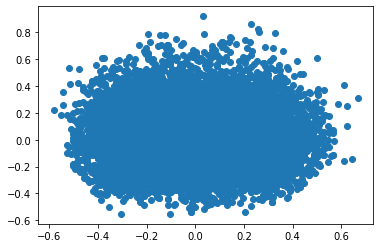

In [14]:
from pandas import read_csv
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

if feature_method == "selection":

    # Feature Importance with Extra Trees Classifier
    X = feature_
    Y = class_
    model = ExtraTreesClassifier(n_estimators=n_estimators) # feature extraction
    model.fit(X, Y)
    importance = model.feature_importances_
    
    # creating dataframe for visualizing important features
    df_ = pd.DataFrame(columns=['features','importance'])
    df_['importance'] = importance
    df_['features'] = ['feature'+str(i) for i in range(importance.shape[0])]

    # pd.set_option('display.max_rows', 10) # set number of rows for display

#     print(df_) # display dataframe
#     print("__________________important features_________________")
    print(df_.nlargest(10,'importance')) # display top 10 important features

elif feature_method == "reduction":
    # Principal componenet analysis to reduce dimensionality
    pca = PCA(n_components=n_components)
    reduced_feature = pca.fit_transform(feature_) # feature extraction
    total_var = pca.explained_variance_ratio_.sum() * 100 # summarize components
    print(total_var) # display total variance in % for selected n_components
    
    # pca = PCA(.80) # set the total variance to find n_components
    # reduced_feature = pca.fit_transform(feature_)
    # num_features = pca.n_components_
    # print(pca.components_.shape) # display number of n components

    # plot the graph between selected n_components
    plt.scatter(reduced_feature[:,0],reduced_feature[:,1])
    
    # creating the dataframe for reduced features
    cols = ['feature'+str(i) for i in range(reduced_feature.shape[1])]
    df_final = pd.DataFrame(reduced_feature, columns=cols)
    df_final['image_name'] = name
    # print(df_final.dtypes) # display data type of the columns
    df_final = df_final.astype({'image_name': 'int64'})  # changing the data type of one column for mergeing
    print(df_final) # display dataframe

In [20]:
# # creating dataframe for top 2 important features
# df_final = pd.DataFrame(columns=['FID','feature_0', 'feature_1', 'class_'])
# df_final['FID'] = df.iloc[: ,512]
# df_final['feature_0'] = df.iloc[: ,398] # df.loc[row_indexer,column_indexer]
# df_final['feature_1'] = df.iloc[: ,14]
# df_final['class_'] = df.iloc[: ,513]
# # print(df_final.dtypes) # display data type of the columns
# df_final = df_final.astype({'FID': 'int64'}) # changing the data type of one column for mergeing
# # print(df_final) # display dataframe

        FID  feature_0  feature_1  class_
0     10001   0.264649   0.000000       1
1     10002   0.000000   0.000000       1
2     10003   0.215142   0.264697       1
3     10005   0.440606   0.000000       1
4     10006   0.000000   0.288025       1
...     ...        ...        ...     ...
9869    995   0.299218   0.304036       0
9870    996   0.315399   0.212700       0
9871    997   0.267551   0.330108       0
9872    998   0.208976   0.496878       0
9873    999   0.353319   0.295441       0

[9874 rows x 4 columns]


In [15]:
# ################################################################
# Merging dataframe of reduced feature with dataframe of  point 
# coordinate file
# ################################################################

point_file = "gsv_point_UTM"
csv_file = pd.read_csv(csv_dir+"/"+point_file+".txt", sep=';')
# print(csv_file.head(5))
# print(csv_file.dtypes)
point_feature = df_final.merge(csv_file, on='image_name', how='inner')

In [16]:
file_name = f"{feature_method}_features"
file_path = feature_dir + "/" + file_name + ".csv"
point_feature.to_csv(file_path, index= False)